In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
import plotly.graph_objs as go
import plotly.express as px
import math

# DISASTERS ANALYSIS

In [2]:
#### uploading CDC SVI data
cvc = pd.read_csv('social_ds.csv')
cvc.head()

,FID,AFFGEOID,TRACTCE,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,...,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,SHAPE_Length,SHAPE_Area
0,1,1400000US36065023400,23400,36,New York,NY,36065,Oneida,36065023400,"Census Tract 234, Oneida County, New York",...,1,1,2,154,125,3.6,2.9,10017,0.176164,0.000699
1,2,1400000US36065023501,23501,36,New York,NY,36065,Oneida,36065023501,"Census Tract 235.01, Oneida County, New York",...,0,0,1,151,100,6.3,4.2,912,0.084156,0.000334
2,3,1400000US36065023502,23502,36,New York,NY,36065,Oneida,36065023502,"Census Tract 235.02, Oneida County, New York",...,0,0,0,131,85,2.9,1.8,3057,0.357314,0.002552
3,4,1400000US36065023702,23702,36,New York,NY,36065,Oneida,36065023702,"Census Tract 237.02, Oneida County, New York",...,0,0,0,385,136,10.2,3.6,1407,0.464853,0.009988
4,5,1400000US36065023901,23901,36,New York,NY,36065,Oneida,36065023901,"Census Tract 239.01, Oneida County, New York",...,0,0,0,165,97,7.2,4.3,1646,0.154148,0.000664


In [3]:
#### uploading Disasters data
dis = pd.read_csv('us_disaster_declarations.csv')
dis.head()

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,...,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,hash,last_refresh,id
0,DR-1-GA,1,GA,DR,1953-05-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-05-02T00:00:00Z,1953-05-02T00:00:00Z,1954-06-01T00:00:00Z,13000,0,Statewide,53013,bb121323c9c29d3bef0c9a3f134bfd8b5ecff148,2021-07-13T23:01:19Z,60c3b7a9a0ee349d71025780
1,DR-2-TX,2,TX,DR,1953-05-15T00:00:00Z,1953,Tornado,Tornado & Heavy Rainfall,0,1,...,1953-05-15T00:00:00Z,1953-05-15T00:00:00Z,1958-01-01T00:00:00Z,48000,0,Statewide,53003,c879557e78d059e6847e7688388c339d10f51979,2021-07-13T23:01:19Z,60c3b7a9a0ee349d71025783
2,DR-3-LA,3,LA,DR,1953-05-29T00:00:00Z,1953,Flood,Flood,0,1,...,1953-05-29T00:00:00Z,1953-05-29T00:00:00Z,1960-02-01T00:00:00Z,22000,0,Statewide,53005,4fb19699fdbba1387ffa2263fcc4a4e37a1de6d6,2021-07-13T23:01:19Z,60c3b7a9a0ee349d71025777
3,DR-4-MI,4,MI,DR,1953-06-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-06-02T00:00:00Z,1953-06-02T00:00:00Z,1956-02-01T00:00:00Z,26000,0,Statewide,53004,87a0c1dd5da249767f545e0c0a43f917e4e9ca83,2021-07-13T23:01:19Z,60c3b7a9a0ee349d7102577a
4,DR-5-MT,5,MT,DR,1953-06-06T00:00:00Z,1953,Flood,Floods,0,1,...,1953-06-06T00:00:00Z,1953-06-06T00:00:00Z,1955-12-01T00:00:00Z,30000,0,Statewide,53006,954449c15634fb45c8bea3ac975782793ccde050,2021-07-13T23:01:19Z,60c3b7a9a0ee349d71025774


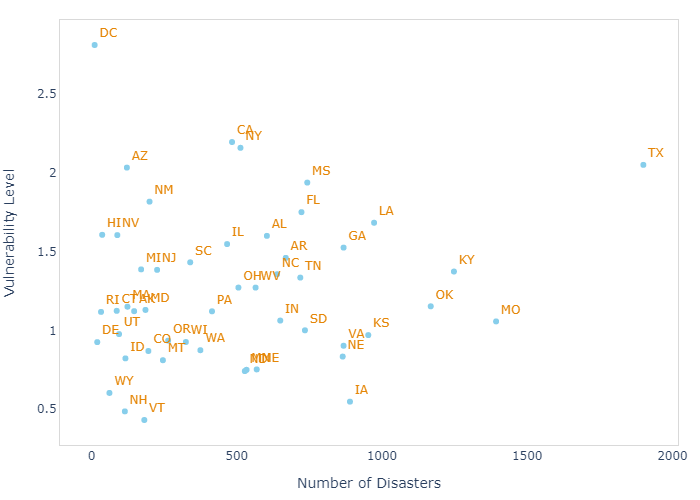

In [4]:
#### calculating the vulnerability percentage per state
dis = dis[(dis.fy_declared>=2000) & (dis.hm_program_declared==1)]
cvc = cvc[~cvc.eq(-999).any(1)]
st_count = cvc.ST_ABBR.value_counts().reset_index()
st_count.rename(columns={'index':'ST_ABBR', 'ST_ABBR':'count'},inplace=True) 
cvc_st = cvc.groupby(['ST_ABBR']).F_TOTAL.sum().reset_index()
cvc_st = cvc_st.merge(st_count,how='left', on=["ST_ABBR"])
cvc_st["vulnera_perc"] =  cvc_st['F_TOTAL']/cvc_st['count']
cvc_st.rename(columns={'ST_ABBR' : 'state'},inplace=True) 
dis_st = dis.groupby(['state']).hm_program_declared.sum().reset_index()
st_grp = cvc_st.merge(dis_st,how='left', on=["state"])
###### Plotting Disasters and Vulnerability by State

layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Number of Disasters',
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True),
              yaxis=dict(title='Vulnerability Level',
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True))

data = go.Scatter(x=st_grp['hm_program_declared'],
                  y=st_grp['vulnera_perc'],
                  text=st_grp['state'],
                  textposition='top right',
                  mode='markers+text',
                  line=dict(color='skyblue', width=1, dash='dash'),
                  textfont=dict(color='#E58606'),
                  name='citations')

fig = go.Figure(data=data, layout=layout)

fig.show("png")

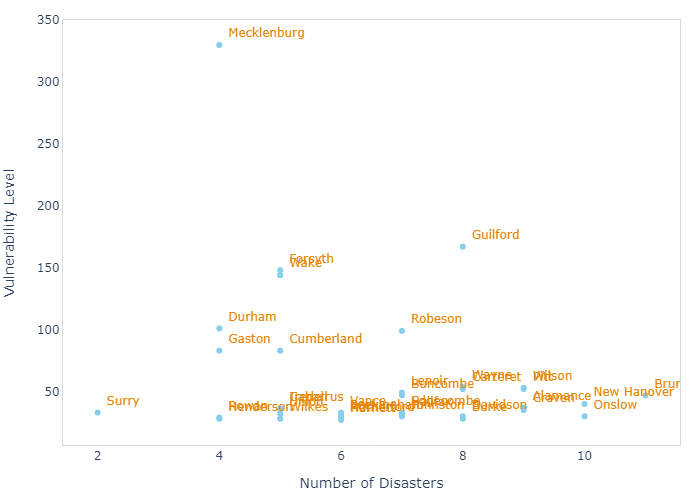

In [5]:
###### Plotting Disasters and Vulnerability by County in NC

cvcnc = cvc[(cvc.ST_ABBR=="NC")]
cvc_ct = cvcnc.groupby(['COUNTY','STCNTY']).F_TOTAL.sum().reset_index()
cvc_ct.rename(columns={'STCNTY' : 'fips'},inplace=True) 
dis_ct = dis.groupby(['fips']).hm_program_declared.sum().reset_index()
ct_grp = cvc_ct.merge(dis_ct,how='left', on=["fips"])
ct_grp = ct_grp.groupby(['COUNTY']).agg({'F_TOTAL':'sum','hm_program_declared':'sum'}).reset_index()
ct_grp2 = ct_grp[ct_grp.F_TOTAL>25]


layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Number of Disasters',
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True),
              yaxis=dict(title='Vulnerability Level',
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True))

data = go.Scatter(x=ct_grp2['hm_program_declared'],
                  y=ct_grp2['F_TOTAL'],
                  text=ct_grp2['COUNTY'],
                  textposition='top right',
                  mode='markers+text',
                  line=dict(color='skyblue', width=1, dash='dash'),
                  textfont=dict(color='#E58606'),
                  name='citations')

fig = go.Figure(data=data, layout=layout)

fig.show("png")

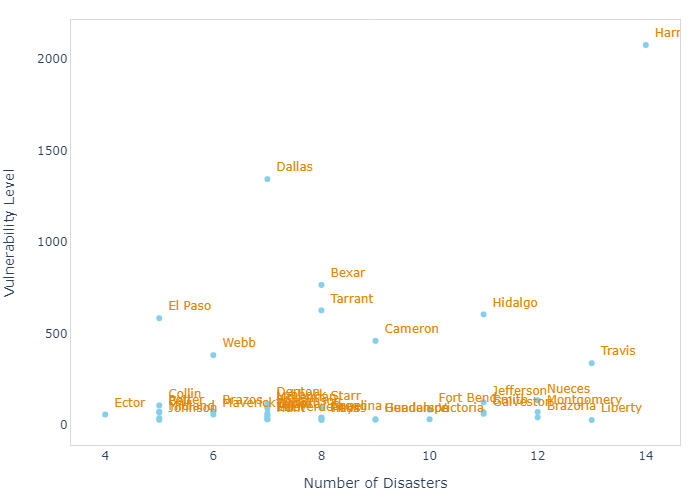

In [6]:
###### Plotting Disasters and Vulnerability by County in Texas

cvcnc = cvc[(cvc.ST_ABBR=="TX")]
cvc_ct = cvcnc.groupby(['COUNTY','STCNTY']).F_TOTAL.sum().reset_index()
cvc_ct.rename(columns={'STCNTY' : 'fips'},inplace=True) 
dis_ct = dis.groupby(['fips']).hm_program_declared.sum().reset_index()
ct_grp = cvc_ct.merge(dis_ct,how='left', on=["fips"])
ct_grp = ct_grp.groupby(['COUNTY']).agg({'F_TOTAL':'sum','hm_program_declared':'sum'}).reset_index()
ct_grp2 = ct_grp[ct_grp.F_TOTAL>25]


layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Number of Disasters',
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True),
              yaxis=dict(title='Vulnerability Level',
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True))

data = go.Scatter(x=ct_grp2['hm_program_declared'],
                  y=ct_grp2['F_TOTAL'],
                  text=ct_grp2['COUNTY'],
                  textposition='top right',
                  mode='markers+text',
                  line=dict(color='skyblue', width=1, dash='dash'),
                  textfont=dict(color='#E58606'),
                  name='citations')

fig = go.Figure(data=data, layout=layout)

fig.show("png")